In [1]:
# to do:
# add a repeatable block to get > 500 records if initial pull did not 
# enhance exceptions handling
# export printing of results into written log txt
# migrate unfound cities and status codes into separate df
# ISO Code Lookup on countries
# How to integrate state/province where appropriate?
# Visible low humidity in deserts

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from citipy import citipy
import time
import requests
from datetime import datetime
from config import weather_api_key
import string
from scipy.stats import linregress

In [3]:
lats = np.random.uniform(low=-90, high=90, size=1500)
longs = np.random.uniform(low=-180, high=90, size=1500)
lat_longs = zip(lats, longs)
lat_longs

In [4]:
base_url = "http://api.openweathermap.org/data/2.5/weather?units=Imperial&appid=" + weather_api_key

In [5]:
coordinates = list(lat_longs)
cities = list()

for coordinate in coordinates:
    city = citipy.nearest_city(latitude=coordinate[0], longitude=coordinate[1])
    if string.capwords(city.city_name) not in cities:
        cities.append(string.capwords(city.city_name)) # capitalizing all names since they came through in lowercase.  source https://favtutor.com/blogs/capitalize-first-letter-python
        
len(cities)

542

In [6]:
city_data = list()


print("Beginning Data Retrieval")
print("-------------------------------------")

record_count = 1
set_count = 1

for i, city in enumerate(cities):
    # group cities in sets of 50 for logging purposes
    if (i % 50 == 0 and i >= 50):
        set_count+=1
        record_count = 1
        # time.sleep(60) # delay execution for 60 seconds.  But why?
        
    city_url = base_url + "&q=" + city.replace(" ","+")
    
    print(f"Processing Record {record_count} of set {set_count} | {city}")
    
    record_count += 1
    
    try:
        #extract the JSON data using API URL
        city_weather = requests.get(city_url).json()
        # print(city_url)
        # print(city_weather)
        
        #parse out data points
        city_lat = city_weather["coord"]["lat"]
        city_long = city_weather["coord"]["lon"]
        city_max_temp = city_weather["main"]["temp_max"]
        city_humidity = city_weather["main"]["humidity"]
        city_clouds = city_weather["clouds"]["all"]
        city_wind = city_weather["wind"]["speed"]
        city_country = city_weather["sys"]["country"]
        
        #convert datetime to ISO
        city_date = datetime.utcfromtimestamp(city_weather["dt"]).strftime('%Y-%m-%d %H:%M:%S')
        
        #add to list
        city_data.append({"City": city,
                          "Lat": city_lat,
                          "Long": city_long,
                          "Max Temp": city_max_temp,
                          "Humidity": city_humidity,
                          "Cloudiness": city_clouds,
                          "Wind Speed": city_wind,
                          "Country": city_country,
                          "Date": city_date
                           })
        
        print(f"{city} processed successfully.")
        
    except:
        #Change me later to print out the error!
        
        status_code = requests.get(city_url).status_code
        
        if status_code == 404:
            print(f"ERROR: City {city} not found.")
        else:
            print(f"ERROR: City {city} not processed. StatusCode: {status_code}")
        pass
    
print("-------------------------------------")
print("Data Retrieval Complete!")
print("-------------------------------------")

Beginning Data Retrieval
-------------------------------------
Processing Record 1 of set 1 | Taolanaro
ERROR: City Taolanaro not found.
Processing Record 2 of set 1 | Jamestown
Jamestown processed successfully.
Processing Record 3 of set 1 | Clonakilty
Clonakilty processed successfully.
Processing Record 4 of set 1 | Tuktoyaktuk
Tuktoyaktuk processed successfully.
Processing Record 5 of set 1 | Atuona
Atuona processed successfully.
Processing Record 6 of set 1 | Mataura
Mataura processed successfully.
Processing Record 7 of set 1 | Hermon
Hermon processed successfully.
Processing Record 8 of set 1 | Frankenburg
Frankenburg processed successfully.
Processing Record 9 of set 1 | Yar-sale
Yar-sale processed successfully.
Processing Record 10 of set 1 | Longyearbyen
Longyearbyen processed successfully.
Processing Record 11 of set 1 | Tasiilaq
Tasiilaq processed successfully.
Processing Record 12 of set 1 | Rolim De Moura
ERROR: City Rolim De Moura not found.
Processing Record 13 of set 1 

In [7]:
city_data_df = pd.DataFrame(city_data)
city_data_df

,City,Lat,Long,Max Temp,Humidity,Cloudiness,Wind Speed,Country,Date
0,Jamestown,42.0970,-79.2353,27.99,85,90,7.00,US,2021-12-22 23:25:38
1,Clonakilty,51.6231,-8.8706,52.81,94,100,20.02,IE,2021-12-22 23:25:39
2,Tuktoyaktuk,69.4541,-133.0374,-5.80,71,90,20.71,CA,2021-12-22 23:25:39
3,Atuona,-9.8000,-139.0333,78.87,77,24,20.42,PF,2021-12-22 23:22:21
4,Mataura,-46.1927,168.8643,56.48,44,35,9.06,NZ,2021-12-22 23:25:40
...,...,...,...,...,...,...,...,...,...
495,Samana,19.2056,-69.3369,80.56,85,40,5.55,DO,2021-12-22 23:28:58
496,Neuquen,-38.9516,-68.0591,87.69,22,0,5.75,AR,2021-12-22 23:28:58
497,Namibe,-15.1961,12.1522,68.20,77,24,9.19,AO,2021-12-22 23:28:59
498,Orange Cove,36.6244,-119.3137,55.45,88,100,1.72,US,2021-12-22 23:28:59


In [8]:
column_order = ["City", "Country", "Date", "Lat", "Long", "Max Temp", "Humidity", "Cloudiness", "Wind Speed"]
city_data_df = city_data_df[column_order]
city_data_df

,City,Country,Date,Lat,Long,Max Temp,Humidity,Cloudiness,Wind Speed
0,Jamestown,US,2021-12-22 23:25:38,42.0970,-79.2353,27.99,85,90,7.00
1,Clonakilty,IE,2021-12-22 23:25:39,51.6231,-8.8706,52.81,94,100,20.02
2,Tuktoyaktuk,CA,2021-12-22 23:25:39,69.4541,-133.0374,-5.80,71,90,20.71
3,Atuona,PF,2021-12-22 23:22:21,-9.8000,-139.0333,78.87,77,24,20.42
4,Mataura,NZ,2021-12-22 23:25:40,-46.1927,168.8643,56.48,44,35,9.06
...,...,...,...,...,...,...,...,...,...
495,Samana,DO,2021-12-22 23:28:58,19.2056,-69.3369,80.56,85,40,5.55
496,Neuquen,AR,2021-12-22 23:28:58,-38.9516,-68.0591,87.69,22,0,5.75
497,Namibe,AO,2021-12-22 23:28:59,-15.1961,12.1522,68.20,77,24,9.19
498,Orange Cove,US,2021-12-22 23:28:59,36.6244,-119.3137,55.45,88,100,1.72


In [9]:
import os.path
output_data_file = os.path.join("weather_data", "cities.csv")
city_data_df.to_csv(output_data_file, index_label="City_ID")

## Plotting climate charts

In [10]:
lats = city_data_df["Lat"]
max_temps = city_data_df["Max Temp"]
humidity = city_data_df["Humidity"]
cloudiness = city_data_df["Cloudiness"]
wind_speed = city_data_df["Wind Speed"]

today = datetime.utcfromtimestamp(time.time()).strftime("%x")

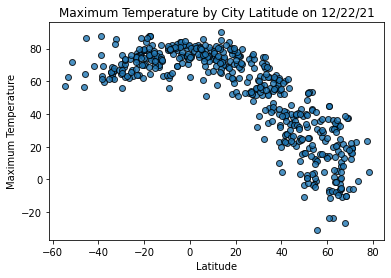

In [11]:
plt.scatter(x = lats,
            y = max_temps,
           edgecolor = "black",
           linewidths=1,
           marker="o",
           alpha=0.8,
           label="Cities")

plt.title(f"Maximum Temperature by City Latitude on {today}")
plt.xlabel("Latitude")
plt.ylabel("Maximum Temperature")

plt.savefig("weather_data/Fig1.png")

plt.show()

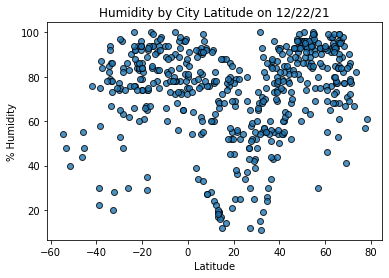

In [12]:
plt.scatter(x = lats,
            y = humidity,
           edgecolor = "black",
           linewidths=1,
           marker="o",
           alpha=0.8,
           label="Cities")

plt.title(f"Humidity by City Latitude on {today}")
plt.xlabel("Latitude")
plt.ylabel("% Humidity")

plt.savefig("weather_data/Fig2.png")

plt.show()

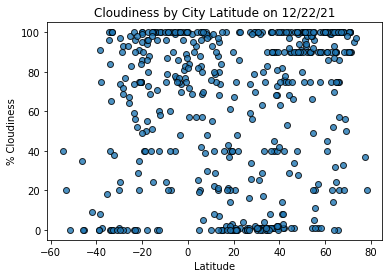

In [13]:
plt.scatter(x = lats,
            y = cloudiness,
           edgecolor = "black",
           linewidths=1,
           marker="o",
           alpha=0.8,
           label="Cities")

plt.title(f"Cloudiness by City Latitude on {today}")
plt.xlabel("Latitude")
plt.ylabel("% Cloudiness")

plt.savefig("weather_data/Fig3.png")

plt.show()

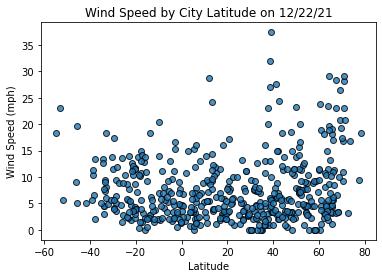

In [14]:
plt.scatter(x = lats,
            y = wind_speed,
           edgecolor = "black",
           linewidths=1,
           marker="o",
           alpha=0.8,
           label="Cities")

plt.title(f"Wind Speed by City Latitude on {today}")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")

plt.savefig("weather_data/Fig4.png")

plt.show()

## Linear regression of collected data

Start by creating function.

In [25]:
def plot_linear_regression(x_values, y_values, title, y_label, text_coordinates):
    #Run linear regression against value inputs
    (slope, intercept, r_value, p_value, std_err) = linregress(x_values, y_values)
    
    # Calculate regression line
    regress_values = x_values * slope + intercept
    
    # Create equation
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    
    # create scatter plot and reg line
    plt.scatter(x=x_values,y=y_values)
    plt.plot(x_values,regress_values,"r")
    plt.ylabel(y_label)
    plt.annotate(line_eq, text_coordinates, fontsize=15, color="red")
    plt.title(title)
    plt.xlabel("Latitude")
    
    plt.show()
    
    print(f"r = {r_value}\np = {p_value}\nstd error = {std_err}")

### Separate latitudes by hemisphere

In [16]:
index13 = city_data_df.loc[13]
index13

City                        Nikki
Country                        BJ
Date          2021-12-22 23:25:44
Lat                        9.9401
Long                       3.2108
Max Temp                    73.87
Humidity                       28
Cloudiness                      0
Wind Speed                   5.26
Name: 13, dtype: object

In [17]:
#boolean expression meant to filter dataframe in loc.  Think where clause
city_data_df["Lat"] >= 0

0       True
1       True
2       True
3      False
4      False
       ...  
495     True
496    False
497    False
498     True
499     True
Name: Lat, Length: 500, dtype: bool

In [18]:
northern_hemi_df = city_data_df.loc[(city_data_df["Lat"] >= 0)]
southern_hemi_df = city_data_df.loc[(city_data_df["Lat"] < 0)]
southern_hemi_df.head()

,City,Country,Date,Lat,Long,Max Temp,Humidity,Cloudiness,Wind Speed
3,Atuona,PF,2021-12-22 23:22:21,-9.8000,-139.0333,78.87,77,24,20.42
4,Mataura,NZ,2021-12-22 23:25:40,-46.1927,168.8643,56.48,44,35,9.06
11,Ushuaia,AR,2021-12-22 23:21:01,-54.8000,-68.3000,56.86,54,40,18.41
14,Maceio,BR,2021-12-22 23:25:44,-9.6658,-35.7353,80.04,89,75,6.91
15,Rikitea,PF,2021-12-22 23:23:11,-23.1203,-134.9692,77.23,76,96,7.76


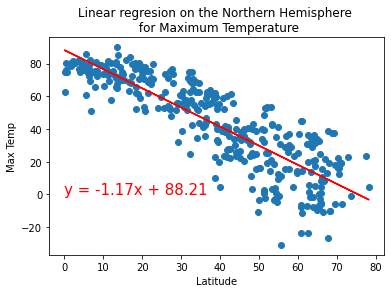

r = -0.8550041353862655
p = 1.5154126192188772e-101
std error = 0.03794780946300781


In [26]:
x_values = northern_hemi_df["Lat"]
y_values = northern_hemi_df["Max Temp"]

plot_linear_regression(x_values,
                       y_values,
                       'Linear regresion on the Northern Hemisphere \n for Maximum Temperature',
                       'Max Temp',
                       (0,0))

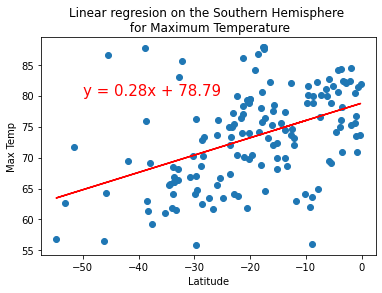

r = 0.4500625156981048
p = 8.480355566851005e-09
std error = 0.04574386318396507


In [27]:
x_values = southern_hemi_df["Lat"]
y_values = southern_hemi_df["Max Temp"]

plot_linear_regression(x_values,
                       y_values,
                       'Linear regresion on the Southern Hemisphere \n for Maximum Temperature',
                       'Max Temp',
                       (-50,80))

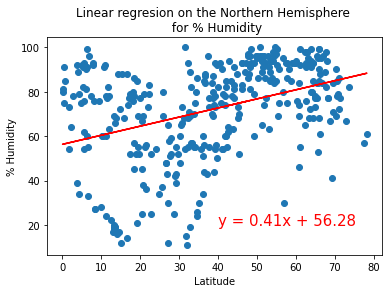

r = 0.384521455056864
p = 8.182475353940247e-14
std error = 0.05261366004599277


In [32]:
x_values = northern_hemi_df["Lat"]
y_values = northern_hemi_df["Humidity"]

plot_linear_regression(x_values,
                       y_values,
                       'Linear regresion on the Northern Hemisphere \n for % Humidity',
                       '% Humidity',
                       (40,20))

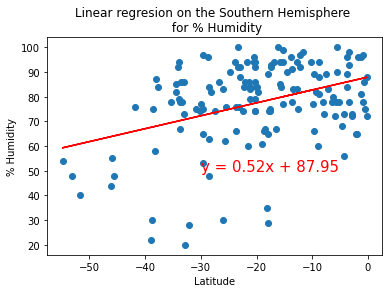

r = 0.38245415800874116
p = 1.4837513022110965e-06
std error = 0.10418396975154481


In [35]:
x_values = southern_hemi_df["Lat"]
y_values = southern_hemi_df["Humidity"]

plot_linear_regression(x_values,
                       y_values,
                       'Linear regresion on the Southern Hemisphere \n for % Humidity',
                       '% Humidity',
                       (-30,50))

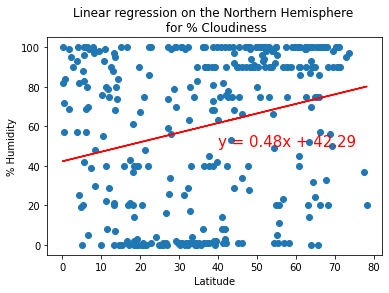

r = 0.2559020304431611
p = 1.1836580201419678e-06
std error = 0.09794172272135482


In [38]:
x_values = northern_hemi_df["Lat"]
y_values = northern_hemi_df["Cloudiness"]

plot_linear_regression(x_values,
                       y_values,
                       'Linear regression on the Northern Hemisphere \n for % Cloudiness',
                       '% Humidity',
                       (40,50))

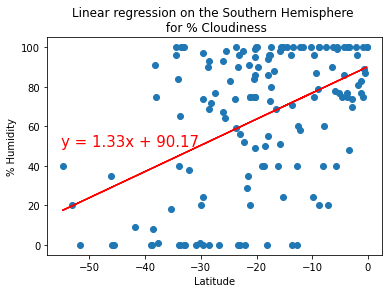

r = 0.4612608589577419
p = 3.215249128707204e-09
std error = 0.21045001144554726


In [40]:
x_values = southern_hemi_df["Lat"]
y_values = southern_hemi_df["Cloudiness"]

plot_linear_regression(x_values,
                       y_values,
                       'Linear regression on the Southern Hemisphere \n for % Cloudiness',
                       '% Humidity',
                       (-55,50))

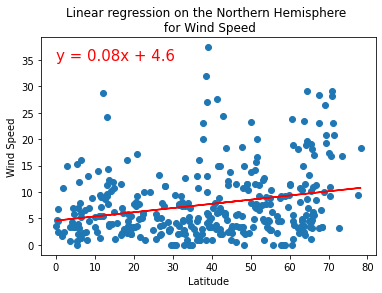

r = 0.24816853718887552
p = 2.5177933264829125e-06
std error = 0.016543919552057355


In [42]:
x_values = northern_hemi_df["Lat"]
y_values = northern_hemi_df["Wind Speed"]

plot_linear_regression(x_values,
                       y_values,
                       'Linear regression on the Northern Hemisphere \n for Wind Speed',
                       'Wind Speed',
                       (0,35))

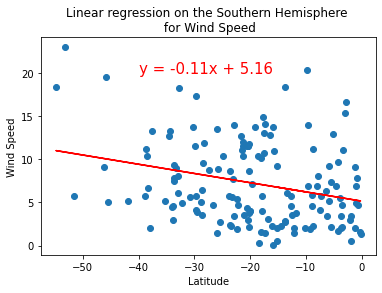

r = -0.27446176557841606
p = 0.0007058248937870107
std error = 0.030911457495031117


In [46]:
x_values = southern_hemi_df["Lat"]
y_values = southern_hemi_df["Wind Speed"]

plot_linear_regression(x_values,
                       y_values,
                       'Linear regression on the Southern Hemisphere \n for Wind Speed',
                       'Wind Speed',
                       (-40,20))